# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 30, 24, 24]           3,780
              ReLU-6           [-1, 30, 24, 24]               0
       BatchNorm2d-7           [-1, 30, 24, 24]              60
           Dropout-8           [-1, 30, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             300
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # Validate the 
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.1870136857032776 Batch_id=468 Accuracy=86.55: 100%|███████████████████████████| 469/469 [00:09<00:00, 49.64it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.14631573855876923 Batch_id=468 Accuracy=95.79: 100%|██████████████████████████| 469/469 [00:09<00:00, 49.74it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9825/10000 (98.25%)

EPOCH: 2


Loss=0.08488088846206665 Batch_id=468 Accuracy=96.70: 100%|██████████████████████████| 469/469 [00:09<00:00, 50.15it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.0638606920838356 Batch_id=468 Accuracy=97.09: 100%|███████████████████████████| 469/469 [00:09<00:00, 49.81it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.1011975109577179 Batch_id=468 Accuracy=97.38: 100%|███████████████████████████| 469/469 [00:09<00:00, 49.97it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.0759788453578949 Batch_id=468 Accuracy=97.71: 100%|███████████████████████████| 469/469 [00:09<00:00, 49.91it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.12569446861743927 Batch_id=468 Accuracy=97.78: 100%|██████████████████████████| 469/469 [00:09<00:00, 49.46it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.14628730714321136 Batch_id=468 Accuracy=97.95: 100%|██████████████████████████| 469/469 [00:09<00:00, 49.59it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.06021365895867348 Batch_id=468 Accuracy=97.92: 100%|██████████████████████████| 469/469 [00:09<00:00, 49.78it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.15297384560108185 Batch_id=468 Accuracy=98.05: 100%|██████████████████████████| 469/469 [00:09<00:00, 49.87it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.07789021730422974 Batch_id=468 Accuracy=98.14: 100%|██████████████████████████| 469/469 [00:09<00:00, 50.33it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.09829746931791306 Batch_id=468 Accuracy=98.22: 100%|██████████████████████████| 469/469 [00:09<00:00, 50.36it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.029534319415688515 Batch_id=468 Accuracy=98.25: 100%|█████████████████████████| 469/469 [00:09<00:00, 50.45it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.024575700983405113 Batch_id=468 Accuracy=98.28: 100%|█████████████████████████| 469/469 [00:09<00:00, 49.85it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


Loss=0.08535465598106384 Batch_id=468 Accuracy=98.29: 100%|██████████████████████████| 469/469 [00:09<00:00, 49.16it/s]



Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99.13%)



Text(0.5, 1.0, 'Test Accuracy')

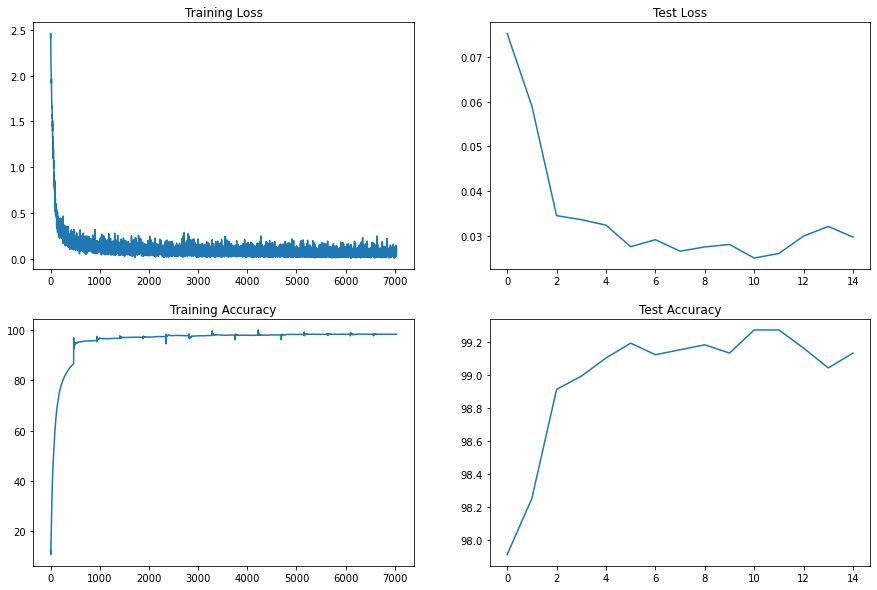

In [11]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Observations
### Target
1. Add one more convolution Layer

### Result 
1. Parameters : 9962
2. Good Train and Test Accuracy : 98.29% and 99.27%

### Analysis
1. Model is bit Overfitting.
2. Will add Learning Rate and will check the results in the further run

### Model Used

In_channels Output_channels Kernel_Size

## 1. Convolution Block 1
Conv2D:  1, 14, 3  Output: 26x26x14

Conv2D: 14, 30, 3  Output: 24x24x30

## 2. Transition Block(Covolution+Max Pool)
Conv2D: 30, 10, 1 Output: 24x24x10 

MaxPool2D: 2x2    Output: 12x12x10

## 3. Convolution Block 2
Conv2D: 10, 14, 3 Output: 10x10x14

Conv2D: 14, 15, 3 Output: 8x8x15

Conv2D: 15, 15, 3 Output: 6x6x15


## 4. Global Average Pooling

AvgPool2D: 6x6     Output: 1x1x15

## 5. Convolution Block 3
Conv2D: 15, 15, 1  Output: 1x1x15

Conv2D: 15, 10, 1  Output: 1x1x10
